# Audio Language Model (AWD-LSTM)

## System setup

There are a few system libraries and Python packages required to work with audio. If needed, uncomment and run this cell.

Note that the cell returns an error code whether there's an error or not. This seems to be due to Jupyter's shell command handling. You'll need to read the outputs in the cell to determine whether anything actually went wrong - sorry!

In [1]:
# Run this cell first!
# %%bash
# ./install.sh
# ./buildFastAiAudio.sh

<span style="color:red">**Don't forget to restart your notebook kernel after you've installed these modules!**</span> 

### fastai default setup

In [2]:
## Notebook settings
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
## fastai imports
from fastai.basics import *
from fastai.data_block import ItemList
from fastai.vision import *

Import FastAI Audio modules here:

In [4]:
from exp.nb_AudioCommon import *
from exp.nb_DataBlock import *
from exp.nb_DataBlockSequence import *
from exp.nb_DataAugmentation import *

### Other library imports

If this cell fails, you probably haven't installed the correct system/Python dependencies. You might need to re-run the "System setup" cell again.

In [5]:
import torch
from pdb import set_trace
from IPython.display import Audio
from pydub import AudioSegment, silence
import torchaudio
from torchaudio import transforms

In [6]:
## The actual url is http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS.tgz
## but we need to strip off the extension otherwise fastai gets confused.
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
## Need this because the source tar file doesn't extract to its own folder
data_folder = datapath4file(url2name(data_url))

In [7]:
untar_data(data_url, dest = data_folder)

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/ST-AEDS-20180100_1-OS')

In [8]:
data_folder.ls()[:5]

[PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0004_us_f0004_00446.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/m0002_us_m0002_00128.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0003_us_f0003_00279.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0001_us_f0001_00168.wav'),
 PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS/f0005_us_f0005_00286.wav')]

In [9]:
data_folder

PosixPath('/home/jupyter/.fastai/data/ST-AEDS-20180100_1-OS')

In [10]:
import glob

In [11]:
wavs = glob.glob(str(data_folder/'**/*.wav'), recursive=True)

In [12]:
twenty_percent = int(len(wavs) * 0.2)

In [13]:
train_data = []
valid_data = []
for wav in wavs[:-twenty_percent]:
    train_data.append(AudioSequenceItem.from_file(wav, sample_len=100, stride_len=50, max_seqs=300))
for wav in wavs[-twenty_percent:]:
    valid_data.append(AudioSequenceItem.from_file(wav, sample_len=100, stride_len=50, max_seqs=300))

In [14]:
train_data[:2], valid_data[:2]

([AudioSequenceItem Length: 300 | Shape: torch.Size([100]) | Sample Rate: 16000,
  AudioSequenceItem Length: 300 | Shape: torch.Size([100]) | Sample Rate: 16000],
 [AudioSequenceItem Length: 300 | Shape: torch.Size([100]) | Sample Rate: 16000,
  AudioSequenceItem Length: 300 | Shape: torch.Size([100]) | Sample Rate: 16000])

In [15]:
train_df = pd.DataFrame(train_data)
valid_df = pd.DataFrame(valid_data)

db = AudioSequenceDataBunch.from_df(Path('.'), train_df, valid_df, bs=32);
len(db.train_ds), len(db.valid_ds)

(3074, 768)

In [16]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=100, hidden_size=512):
        super().__init__()
        self.rnns = nn.ModuleList([
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
        ])
        
    def forward(self, *xb):
        outputs = []
        hiddens = []
        hidden = None
        for x in xb:
            input = x.unsqueeze(0)
            hidden = None
            for rnn in self.rnns:
                out, hidden = rnn(input, hidden)
                outputs.append(out)
                hiddens.append(hidden)
        return out

In [17]:
lstm = SimpleLSTM(); lstm.cuda()
learn = Learner(db, lstm, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


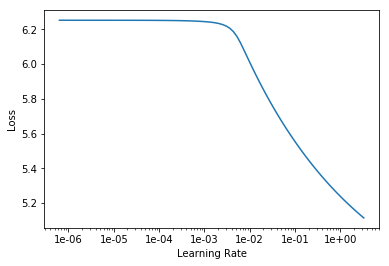

In [18]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,5.690682,4.565272,00:26
1,4.595684,4.420491,00:26
2,4.436524,4.406884,00:26
3,4.408462,4.402801,00:25
4,4.403066,4.402157,00:26


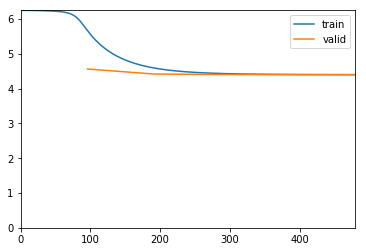

In [19]:
learn.fit_one_cycle(5, max_lr=1e-03)

In [ ]:
learn.predict(db.valid_ds.x[-100]);

## AWD_LSTM with Spectrogram

Remake databunch with spectrogram:

In [16]:
spectro_train_data = []
spectro_valid_data = []
TEN_MS_AT_16000_SR = 160
spec_params = {
    "spectro": True,
    "to_db_scale": True,
    "ws": TEN_MS_AT_16000_SR,
    "n_mels": 128,
}
for wav in wavs[:-twenty_percent]:
    spectro_train_data.append(AudioSequenceItem.from_file(wav, **spec_params))
for wav in wavs[-twenty_percent:]:
    spectro_valid_data.append(AudioSequenceItem.from_file(wav, **spec_params))

In [17]:
spectro_train_df = pd.DataFrame(spectro_train_data)
spectro_valid_df = pd.DataFrame(spectro_valid_data)

spectro_db = AudioSequenceDataBunch.from_df(Path('.'), spectro_train_df, spectro_valid_df, bs=32);
len(spectro_db.train_ds), len(spectro_db.valid_ds)

(3074, 768)

In [19]:
num_features = spectro_db.train_ds.x[0].shape[0]
print('Number of Features:', spectro_db.train_ds.x[0].shape[0])

Number of Features: 128


In [20]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_size=128, hidden_size=512):
        super().__init__()
        self.rnns = nn.ModuleList([
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
            nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=1),
        ])
        
    def forward(self, *xb):
        outputs = []
        hiddens = []
        hidden = None
        for x in xb:
            input = x.unsqueeze(0)
            hidden = None
            for rnn in self.rnns:
                out, hidden = rnn(input, hidden)
                outputs.append(out)
                hiddens.append(hidden)
        return out

In [21]:
lstm = SimpleLSTM(input_size=num_features); lstm.cuda()
learn = Learner(spectro_db, lstm, callback_fns=ShowGraph)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


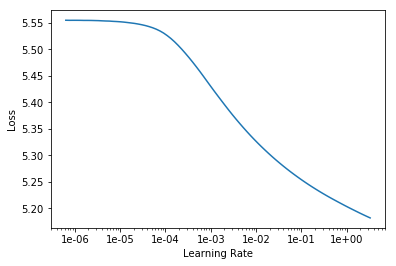

In [22]:
lr_find(learn)
learn.recorder.plot()

epoch,train_loss,valid_loss,time
0,5.105655,5.052288,00:22
1,5.052349,5.041251,00:22
2,5.042510,5.040848,00:21


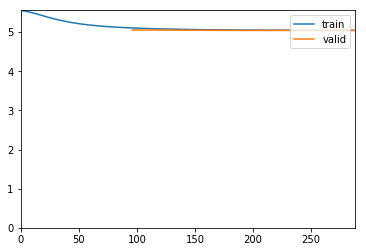

In [23]:
learn.fit_one_cycle(3, max_lr=1e-03)

### AWD_LSTM Schema

```
SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(8758, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(8758, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1150, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1150, 1150, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1150, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=8758, bias=True)
    (output_dp): RNNDropout()
  )
)
```

## Fin.